In [ ]:
import matplotlib.pyplot as plt
from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.devices.pyramid_wfs import PyramidWFS

import xupy as xp
from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid
from numpy.ma import masked_array

from arte.utils.radial_profile import computeRadialProfile



[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
tn = 'master_single_stage'

ssao = SingleStageAO(tn)
ssao.initialize_turbulence('ekarus_3.5cm')
KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=5)
Rec, IM = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, ampsInM=50e-9, save_prefix='')
ssao.sc.load_reconstructor(IM,m2c)

lambdaRef = ssao.pyr.lambdaInM

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Fried parameter is: 10.0 [cm] (seeing = 1.01")


Text(0.5, 1.0, 'Difference')

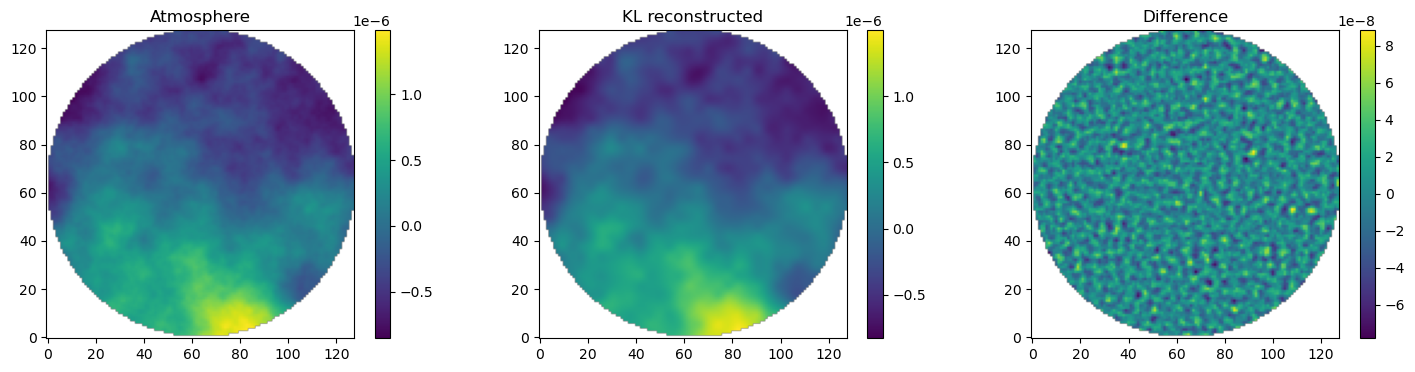

In [3]:
atmo_phase = ssao.get_phasescreen_at_time(0.6)
atmo_phase -= xp.mean(atmo_phase[~ssao.cmask])

phi = atmo_phase[~ssao.cmask]
modes = xp.linalg.pinv(KL.T) @ phi

rec_phi = KL.T @ modes
rec_phase = reshape_on_mask(rec_phi, ssao.cmask)

delta_phase = atmo_phase - rec_phase

sh = 1.0

plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(xp.asnumpy(atmo_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('Atmosphere')
plt.subplot(1,3,2)
plt.imshow(masked_array(xp.asnumpy(rec_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('KL reconstructed')
plt.subplot(1,3,3)
plt.imshow(masked_array(xp.asnumpy(delta_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('Difference')

# print(f'RMS of the reconstructed phase is: {xp.sqrt(xp.sum(rec_phi**2)/len(rec_phi))*1e+9:1.2f} [nm], sum of KL coefficients is: {xp.sum(abs(modes))*1e+9:1.2f} [nm]')

In [4]:
pupilDiameterInM = 8
lambdaInM = 750e-9
oversampling = 4
lambdaOverD = lambdaInM/pupilDiameterInM


apex_angle = 100*(2*xp.pi)*lambdaOverD
wfs = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM)
wfs.set_modulation_angle(0.0)

Modulating 0 [lambda/D] with 0 modulation steps


In [ ]:
def get_mtf(wfs, phase, mask):

    phase_in_rad = reshape_on_mask(phase, mask)*2*xp.pi/wfs.lambdaInM
    input_field = (1-mask) * xp.exp(1j*phase_in_rad,dtype=wfs.cdtype)

    L = max(input_field.shape)
    padded_field = xp.pad(input_field, int((wfs.oversampling-1)/2*L), mode='constant', constant_values=0.0)
    phase_delay = wfs.pyramid_phase_delay(padded_field.shape) / lambdaOverD

    if wfs._modNsteps > 0:
        intensity = xp.zeros(padded_field.shape,dtype=wfs.dtype)
        tiltX,tiltY = wfs._get_XY_tilt_planes(padded_field.shape)
        alpha_pix = wfs.modulationAngleInLambdaOverD*wfs.oversampling*(2*xp.pi)
        phi_vec = (2*xp.pi)*xp.arange(wfs._modNsteps)/wfs._modNsteps

        for phi in phi_vec:
            tilt = tiltX * xp.cos(phi) + tiltY * xp.sin(phi)
            tilted_input = padded_field * xp.exp(1j*tilt*alpha_pix, dtype=wfs.cdtype)
            field_on_focal_plane = xp.fft.fftshift(xp.fft.fft2(tilted_input))
            ef_focal_plane_delayed = field_on_focal_plane * xp.exp(1j*phase_delay, dtype=wfs.cdtype)
            intensity += xp.abs(ef_focal_plane_delayed)**2 / wfs._modNsteps
    else:
        field_on_focal_plane = xp.fft.fftshift(xp.fft.fft2(padded_field))
        ef_focal_plane_delayed = field_on_focal_plane * xp.exp(1j*phase_delay, dtype=wfs.cdtype)
        intensity = xp.abs(ef_focal_plane_delayed)**2

    otf = xp.fft.fftshift(xp.fft.fft2(intensity))
    mtf = abs(otf)

    # padded_mask = xp.abs(padded_field) != 0

    plt.figure()
    plt.imshow(xp.asnumpy(xp.log(mtf)),origin='lower',cmap='twilight')
    # plt.imshow(masked_array(xp.asnumpy(xp.log(mtf)),xp.asnumpy(~padded_mask)),origin='lower',cmap='twilight')
    plt.colorbar()

    return mtf

In [ ]:

# def radial_order(i_mode):
#     noll = i_mode + 2
#     return xp.ceil(-3.0/2.0+xp.sqrt(1+8*noll)/2.0)

# corr_gains = 1.0/xp.sqrt(radial_order(xp.arange(KL.shape[0])))
# print(corr_gains)

# pc_modes = modes*corr_gains
# rec_phi_pc = KL.T @ pc_modes

[1.         1.         0.70710678 0.70710678 0.70710678 0.57735027
 0.57735027 0.57735027 0.57735027 0.5        0.5        0.5
 0.5        0.5        0.4472136  0.4472136  0.4472136  0.4472136
 0.4472136  0.4472136  0.40824829 0.40824829 0.40824829 0.40824829
 0.40824829 0.40824829 0.40824829 0.37796447 0.37796447 0.37796447
 0.37796447 0.37796447 0.37796447 0.37796447 0.37796447 0.35355339
 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777
 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777 0.30151134
 0.30151134 0.30151134 0.30151134 0.30151134 0.30151134 0.30151134
 0.30151134 0.30151134 0.30151134 0.30151134 0.30151134 0.28867513
 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513
 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513
 0.

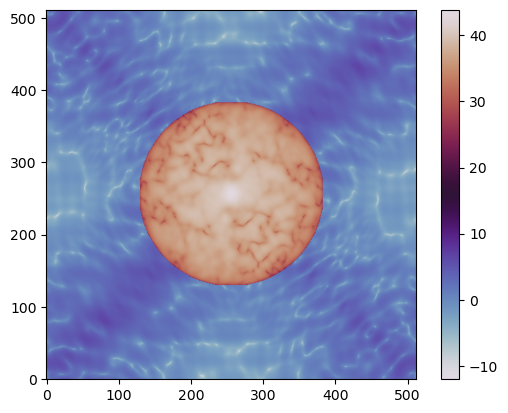

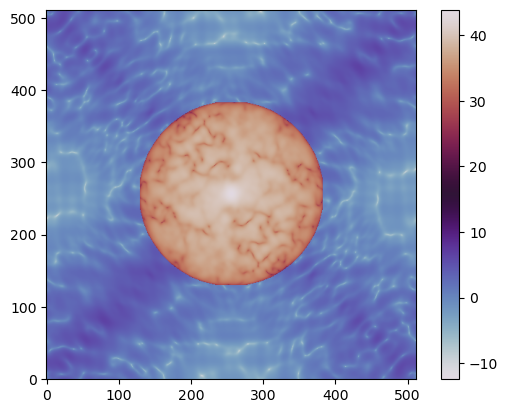

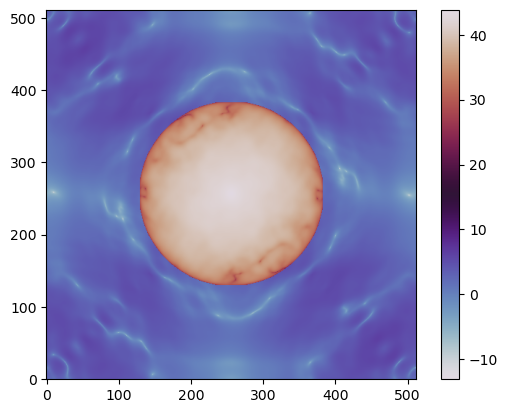

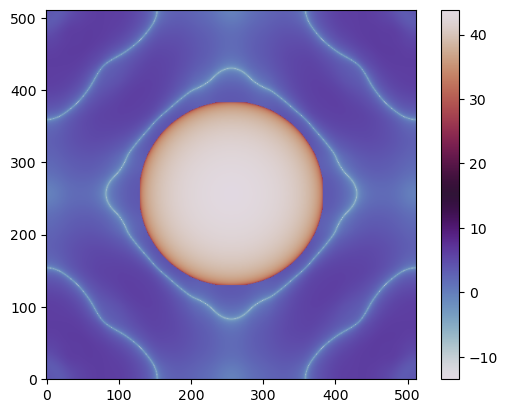

In [7]:
mtf = get_mtf(wfs, phi, ssao.cmask)
rmtf = get_mtf(wfs, rec_phi, ssao.cmask)
dmtf = get_mtf(wfs, phi-rec_phi_pc, ssao.cmask)
mtf0 = get_mtf(wfs, phi*0, ssao.cmask)

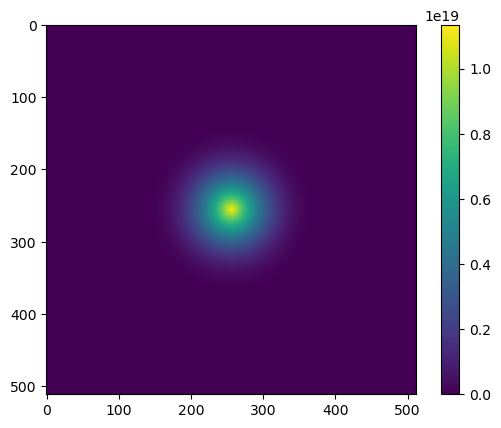

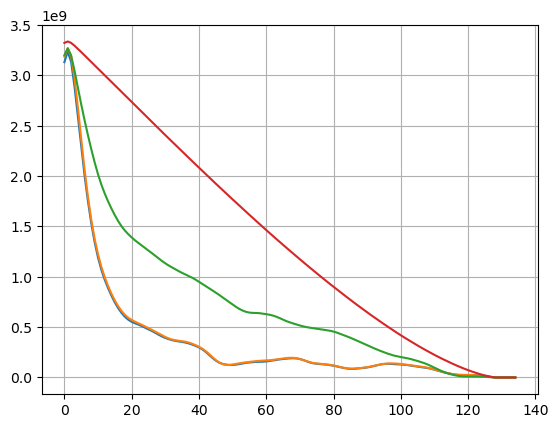

In [16]:
plt.figure()
plt.imshow(xp.asnumpy(mtf0))
plt.colorbar()

plt.figure()
plt.plot(xp.asnumpy(xp.sqrt(mtf[255,255:390])))
plt.plot(xp.asnumpy(xp.sqrt(rmtf[255,255:390])))
plt.plot(xp.asnumpy(xp.sqrt(dmtf[255,255:390])))
plt.plot(xp.asnumpy(xp.sqrt(mtf0[255,255:390])))
plt.grid()
# plt.yscale('log')
# plt.yscale('log')

/tmp/ipykernel_101940/1204365830.py:34: RuntimeWarning: invalid value encountered in divide
  plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy((rad_mtf/rad_mtf0)[:Nmax]),'-+',label='ratio of rad profiles')
/tmp/ipykernel_101940/1204365830.py:53: RuntimeWarning: invalid value encountered in divide
  plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy((rad_dmtf/rad_mtf0)[:Nmax]),'-+',label='ratio of rad profiles')


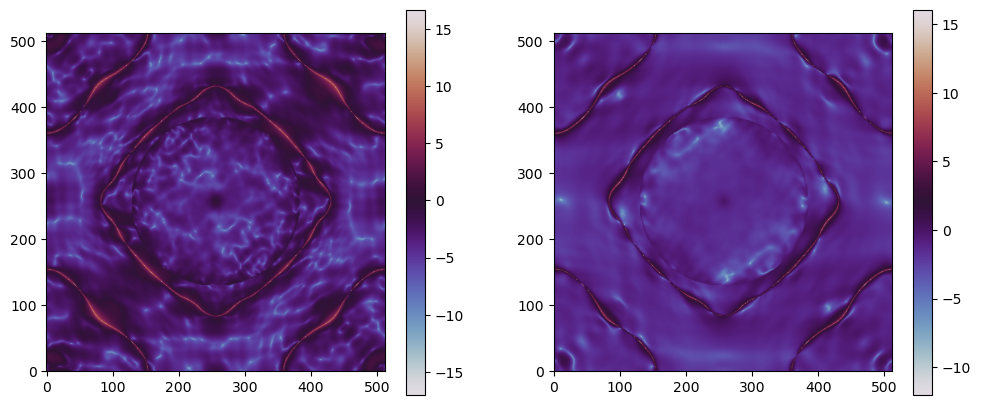

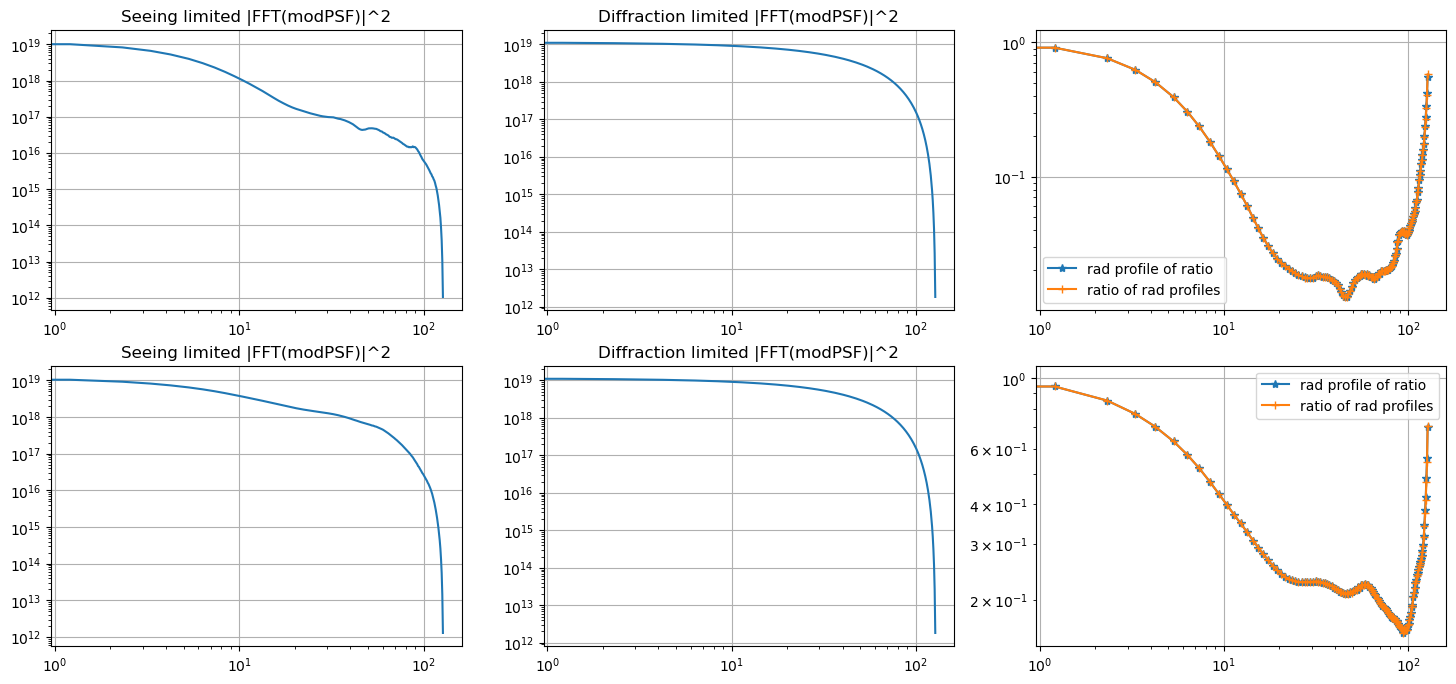

In [17]:
ratio = mtf/mtf0
dratio = dmtf/mtf0
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(xp.log(ratio)),origin='lower',cmap='twilight')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(xp.log(dratio)),origin='lower',cmap='twilight')
plt.colorbar()

Npix = max(xp.shape(dratio))
rad_mtf, distance = computeRadialProfile(xp.asnumpy(mtf), centerInPxX=Npix//2, centerInPxY=Npix//2)
rad_dmtf, distance = computeRadialProfile(xp.asnumpy(dmtf), centerInPxX=Npix//2, centerInPxY=Npix//2)
rad_mtf0, distance = computeRadialProfile(xp.asnumpy(mtf0), centerInPxX=Npix//2, centerInPxY=Npix//2)
rad_ratio, distance = computeRadialProfile(xp.asnumpy(ratio), centerInPxX=Npix//2, centerInPxY=Npix//2)
rad_dratio, distance = computeRadialProfile(xp.asnumpy(dratio), centerInPxX=Npix//2, centerInPxY=Npix//2)

Nmax = 128
plt.figure(figsize=(18,8))
plt.subplot(2,3,1)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_mtf[:Nmax]))
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Seeing limited |FFT(modPSF)|^2')
plt.subplot(2,3,2)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_mtf0[:Nmax]))
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Diffraction limited |FFT(modPSF)|^2')
plt.subplot(2,3,3)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_ratio[:Nmax]),'-*',label='rad profile of ratio')
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy((rad_mtf/rad_mtf0)[:Nmax]),'-+',label='ratio of rad profiles')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.subplot(2,3,4)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_dmtf[:Nmax]))
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Seeing limited |FFT(modPSF)|^2')
plt.subplot(2,3,5)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_mtf0[:Nmax]))
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Diffraction limited |FFT(modPSF)|^2')
plt.subplot(2,3,6)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_dratio[:Nmax]),'-*',label='rad profile of ratio')
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy((rad_dmtf/rad_mtf0)[:Nmax]),'-+',label='ratio of rad profiles')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [ ]:
x,y = ssao.dm.act_coords

IFs = ssao.dm.IFF.copy()
Rec = xp.linalg.pinv(IFs)

mask = ssao.dm.mask.copy()
X,Y = image_grid(mask.shape,recenter=True)
X = X[~mask]
Y = Y[~mask]

# N = 64
# M = int(xp.sum(1-mask))
# s = xp.pi / (xp.max(X) - xp.min(X))
# idx = xp.arange(N, dtype=int)[:, None] 
# ma_cosX = xp.cos(idx * s * X[None, :])
# ma_cosY = xp.cos(idx * s * Y[None, :])
# # build full basis by broadcasting: result shape (N, N, M) -> reshape to (N*N, M)",
# fourier_mat = (ma_cosX[:, None, :] * ma_cosY[None, :, :]).reshape(N*N, M)
# # optional: free temporary arrays",
# del ma_cosX, ma_cosY

# fourier_inv = xp.linalg.pinv(fourier_mat)

In [10]:
# phi_fit = delta_phase[~ssao.cmask]
# phi_fit *= 2*xp.pi/lambdaRef

# off_slopes = ssao._get_slopes(ssao.sc, KL, lambdaRef, amp, phase_offset=phi_fit)
# ref_slopes = ssao._get_slopes(ssao.sc, KL, lambdaRef, amp)

In [11]:
# ref_IM = ref_slopes.T
# off_IM = off_slopes.T

# plt.figure()
# plt.plot(xp.asnumpy(xp.std(ref_IM,axis=0)),label='reference')
# plt.plot(xp.asnumpy(xp.std(off_IM,axis=0)),label='offset')
# plt.legend()
# plt.grid()


In [12]:
# off_Rec = xp.linalg.pinv(off_IM)
# ref_Rec = xp.linalg.pinv(ref_IM)

In [13]:
# Nmodes= xp.shape(KL)[0]
# electric_field_amp = 1-ssao.cmask
# lambdaOverD = lambdaRef/ssao.pupilSizeInM

# opt_gains = xp.zeros(Nmodes)
# ref_gains = xp.zeros(Nmodes)

# for i in range(Nmodes):
#     print(f'\rMode {i:1.0f}/{Nmodes:1.0f}',end='\r',flush=True)
#     mode_phase = reshape_on_mask(KL[i,:]*amp + phi_fit, ssao.cmask)
#     input_field = electric_field_amp * xp.exp(1j*mode_phase)
#     slope = ssao.sc.compute_slopes(input_field, lambdaOverD, None)
#     rec_mode = off_Rec @ slope
#     opt_gains[i] = rec_mode[i]/amp
#     rec_mode = ref_Rec @ slope
#     ref_gains[i] = rec_mode[i]/amp


In [14]:
# plt.figure()
# plt.plot(xp.asnumpy(ref_gains),'-.',label='0-point calibration')
# plt.xlim([0,200])
# plt.grid()

In [15]:
# plt.figure()
# plt.plot(xp.asnumpy(ref_gains),'-.',label='0-point calibration')
# plt.plot(xp.asnumpy(opt_gains),'-.',label='offset calibration')
# plt.legend()
# plt.xscale('log')
# plt.grid()